In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import sys

In [2]:
(x_train,_),(__,___) = tf.keras.datasets.mnist.load_data()
# scale input to -1 -> 1
data_set = (x_train-127.5)/127.5
data_set = np.expand_dims(data_set,axis=-1)

In [3]:
class data:
    def __init__(self,dataset,batch_size):
        self.dataset = dataset
        self.size = len(dataset)
        self.bs = batch_size
        self.lower = 0
        self.upper = 0
        self.batch_count = 0
        self.total_batches = 0
        self.low_up = []
        self.create_batch()
        
    def create_batch(self):
        while (self.upper<self.size):
            self.upper = self.lower+self.bs
            if (self.upper > self.size):
                self.upper = self.size
            self.low_up.append((self.lower,self.upper))
            self.lower = self.upper
        self.total_batches = len(self.low_up)
    def get_batch(self):
        l,u = self.low_up[self.batch_count]
        batch = self.dataset[l:u]
        self.batch_count+=1
        if self.batch_count >= self.total_batches:
            self.batch_count = 0
        return batch

In [4]:
BATCH_SIZE = 256
latent_dims = 100
mydata = data(data_set,BATCH_SIZE)

In [5]:
tf.reset_default_graph()

In [6]:
# Generator
def generator(z):
    with tf.variable_scope('generator'):
        #256 filters layer kernel size 7*7
        x = tf.layers.Dense(256*7*7)(z)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.leaky_relu(x)
        # Reshape into convolution layer with size 7x7 and 256 filter
        x = tf.reshape(x,shape=[-1,7,7,256])
        # Output size of deconvolution = stride * (input_size-1) + kernel_size - 2*padding (padding = 0 for 'valid')
        # ex: 2(stride) * (7(input) - 1) + 2(kernel) - 2*0(padding) = 14
        x = tf.layers.Conv2DTranspose(filters=128,kernel_size=2,strides=(2,2))(x)
        x = tf.layers.BatchNormalization()(x)
        x = x = tf.nn.leaky_relu(x)
        #ex: 2(stride) * (14(input) - 1) + 2(kernel) - 2*0(padding) = 28
        x = tf.layers.Conv2DTranspose(filters=32,kernel_size=2,strides=(2,2))(x)
        x = tf.layers.BatchNormalization()(x)
        x = x = tf.nn.leaky_relu(x)
        x = tf.layers.Conv2DTranspose(filters=1,kernel_size=1)(x)
        #ex: 1(stride) * (28(input) - 1) + 1(kernel) - 2*0(padding) = 28
        x = tf.nn.tanh(x)
    return x

def discriminator(img):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        x = tf.layers.Conv2D(filters=32,kernel_size=5)(img)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.leaky_relu(x)
        x = tf.layers.Dropout(0.2)(x)
        x = tf.layers.Conv2D(filters=128,kernel_size=5)(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.leaky_relu(x)
        x = tf.layers.Dropout(0.2)(x)
        x = tf.layers.flatten(x)
        x = tf.layers.Dense(32)(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.leaky_relu(x)
        x = tf.layers.Dense(1)(x)
        x = tf.nn.sigmoid(x)
    return x

In [7]:
z = tf.placeholder(name='z',shape=(None,latent_dims),dtype=tf.float32)
x = tf.placeholder(name="x",shape=(None,28,28,1),dtype=tf.float32)

In [8]:
fake_img = generator(z)
fake_pred = discriminator(fake_img)
real_pred= discriminator(x)

dis_loss_real = tf.losses.mean_squared_error(tf.ones_like(real_pred),real_pred)
dis_loss_fake = tf.losses.mean_squared_error(tf.zeros_like(fake_pred),fake_pred)

gen_loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(tf.ones_like(fake_pred),fake_pred))
dis_loss = tf.reduce_mean(dis_loss_fake+dis_loss_real)

In [9]:
gen_variable = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
dis_variable = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
gen_var_count = np.sum([np.prod(v.get_shape().as_list()) for v in gen_variable])
dis_var_count = np.sum([np.prod(v.get_shape().as_list()) for v in dis_variable])
print("gen_var_count:",gen_var_count)
print("dis_var_count:",dis_var_count)
print("total:",gen_var_count+dis_var_count)

gen_var_count: 1440001
dis_var_count: 1742209
total: 3182210


In [10]:
dis_op = tf.train.AdamOptimizer(0.0001)
dis_train = dis_op.minimize(dis_loss,var_list=dis_variable)

gen_op = tf.train.AdamOptimizer(0.0001)
gen_train = gen_op.minimize(gen_loss,var_list=gen_variable)

init = tf.global_variables_initializer()

In [11]:
disLoss_his = []
genLoss_his = []
sess = tf.Session()

In [12]:
sess.run(init)

In [13]:
test_noise = np.random.normal(size=[10,latent_dims])
def show_sample(noise):
    fig = plt.figure()
    plt.set_cmap('gray')
    imgs = sess.run(fake_img,feed_dict={z:noise})
    h = 2
    w = 5
    c = 1
    for i in imgs:
        i = i.reshape(28,28)
        i = i*127.5+127.5
        plt.subplots_adjust(left=None, bottom=0.7, right=2, top=2, wspace=None, hspace=0)
        plt.subplot(h,w,c)
        plt.imshow(i)
        plt.axis('off')
        c+=1

Epoch 0: gl_loss = 0.690738320350647, dl_loss =2.334422242711298e-05


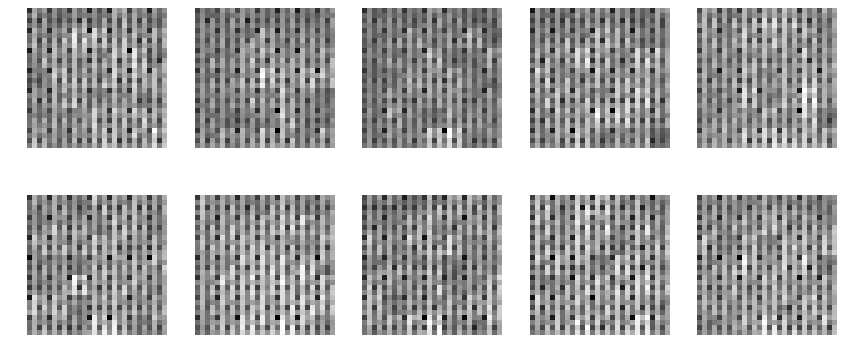

Epoch 1: gl_loss = 0.6921135187149048, dl_loss =4.337960035627475e-06


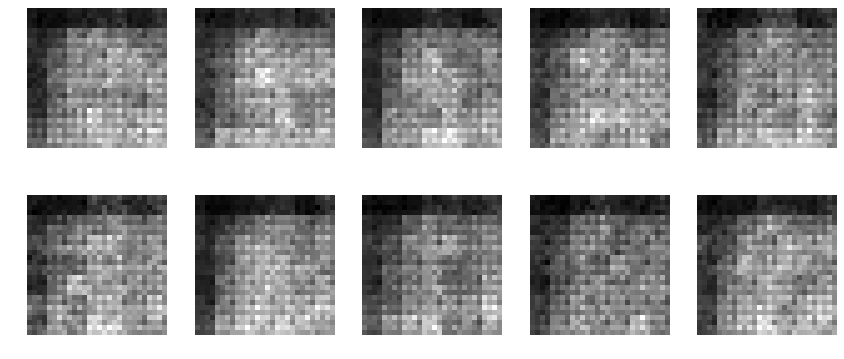

Epoch 2: gl_loss = 0.692309558391571, dl_loss =2.8728798042720882e-06


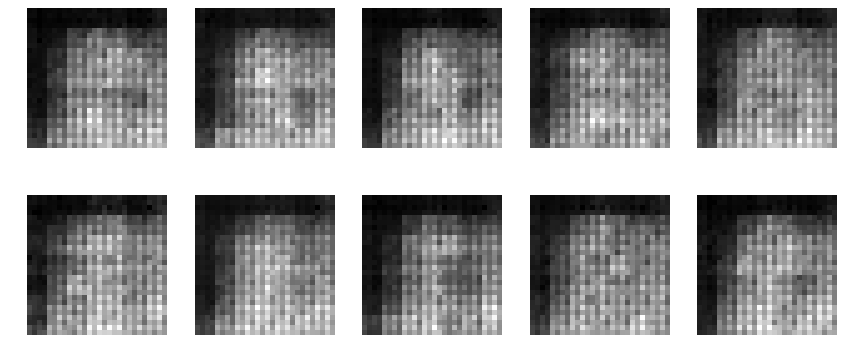

Epoch 3: gl_loss = 0.6923532485961914, dl_loss =2.6140276077057933e-06


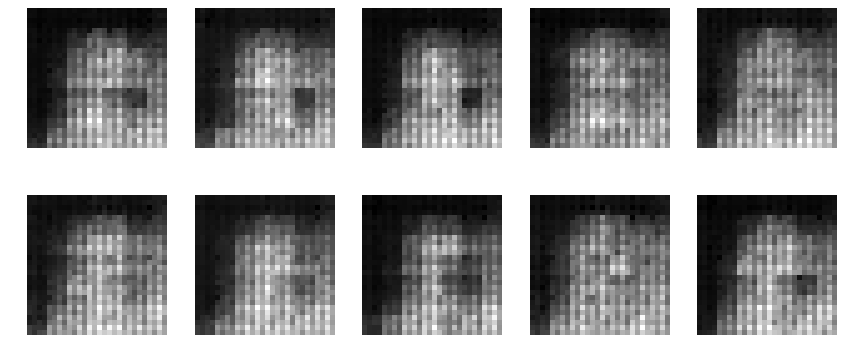

Epoch 4: gl_loss = 0.6923134922981262, dl_loss =3.3819835607573623e-06


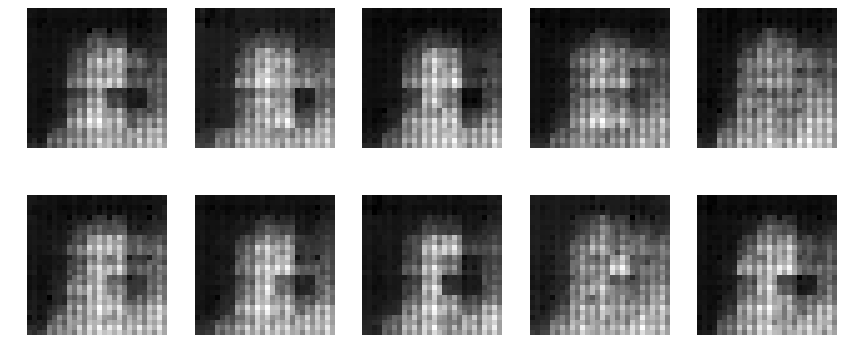

Epoch 5: gl_loss = 0.6912266612052917, dl_loss =0.0003573229187168181


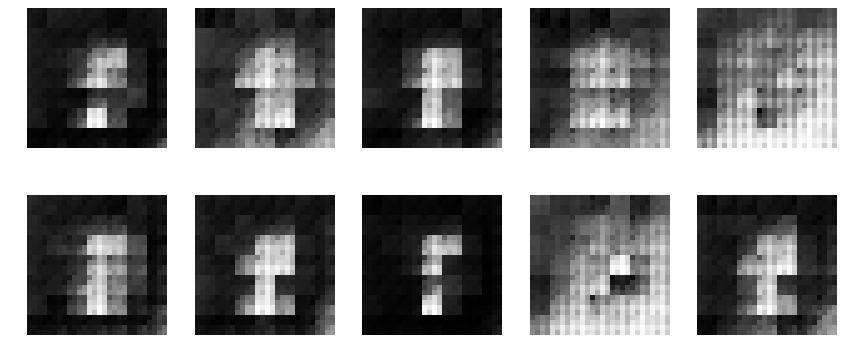

Epoch 6: gl_loss = 0.6914262771606445, dl_loss =0.011899004690349102


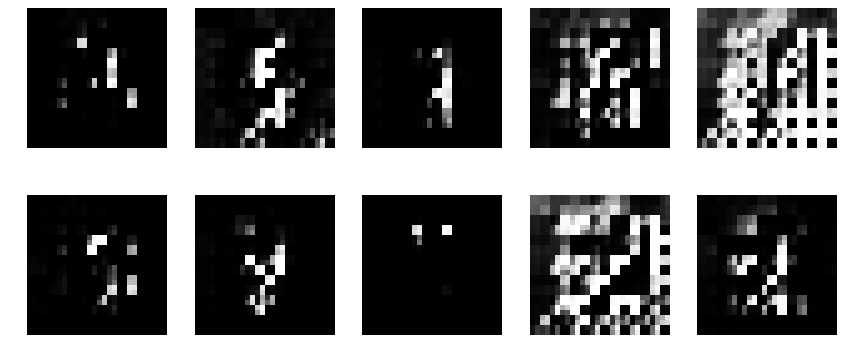

Epoch 7: gl_loss = 0.6904891729354858, dl_loss =0.009348161518573761


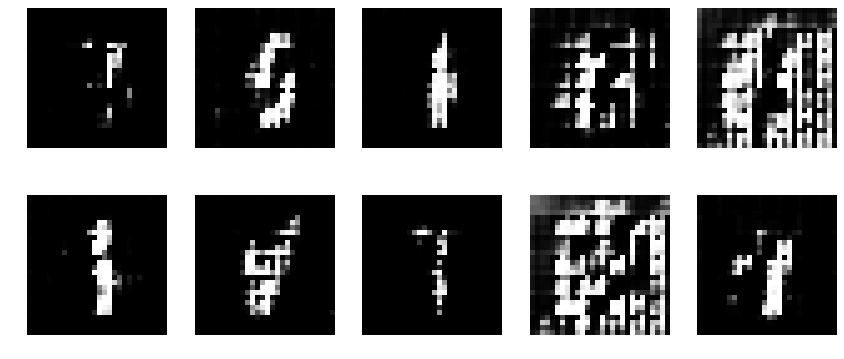

Epoch 8: gl_loss = 0.6280199289321899, dl_loss =0.10545404255390167


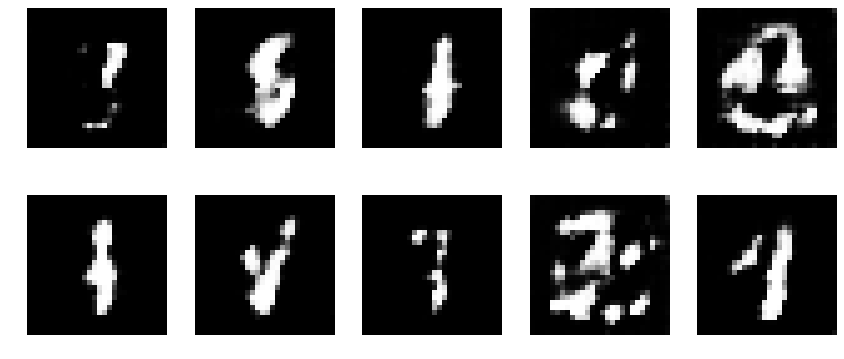

Epoch 9: gl_loss = 0.6180431842803955, dl_loss =0.0909222960472107


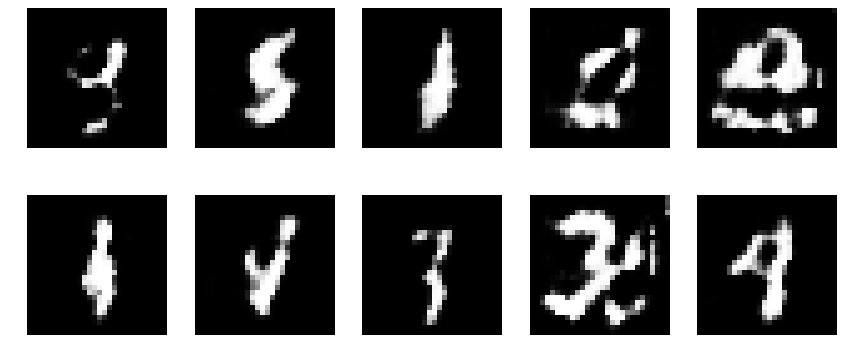

Epoch 10: gl_loss = 0.6163516044616699, dl_loss =0.0998176634311676


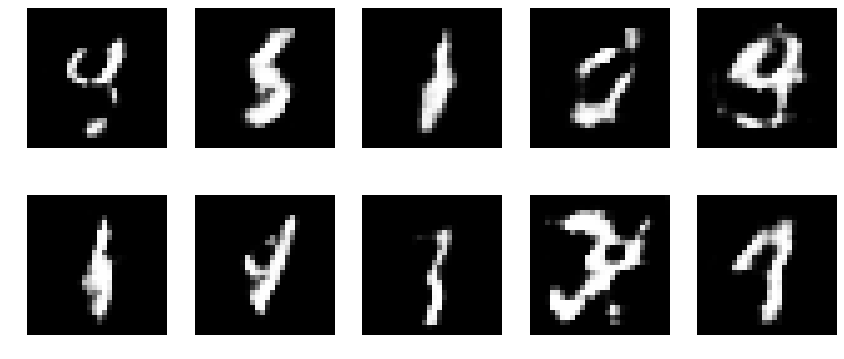

Epoch 11: gl_loss = 0.5990442633628845, dl_loss =0.13136817514896393


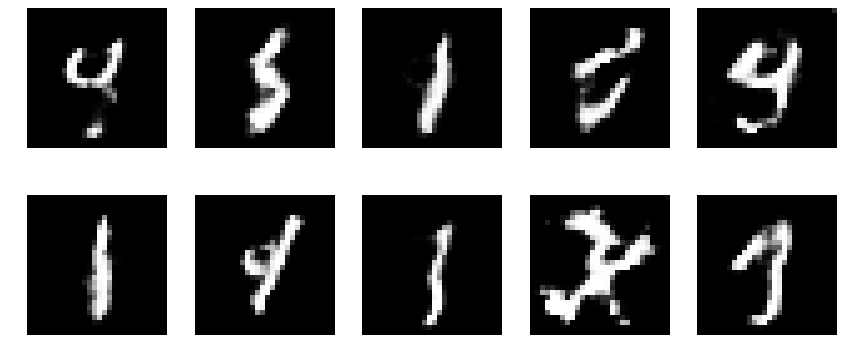

Epoch 12: gl_loss = 0.5918703079223633, dl_loss =0.1718529313802719


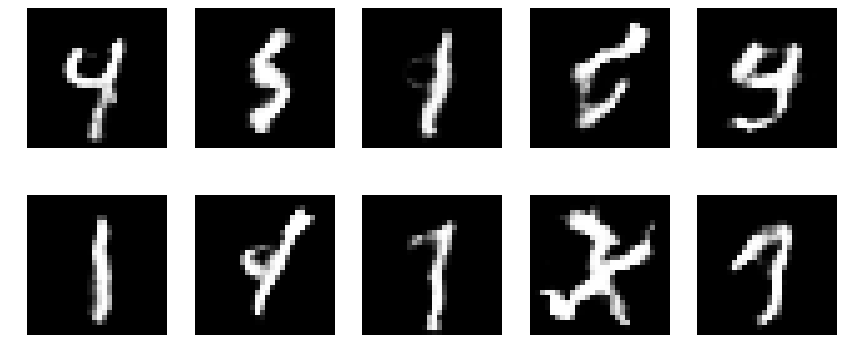

Epoch 13: gl_loss = 0.5843268632888794, dl_loss =0.2380087673664093


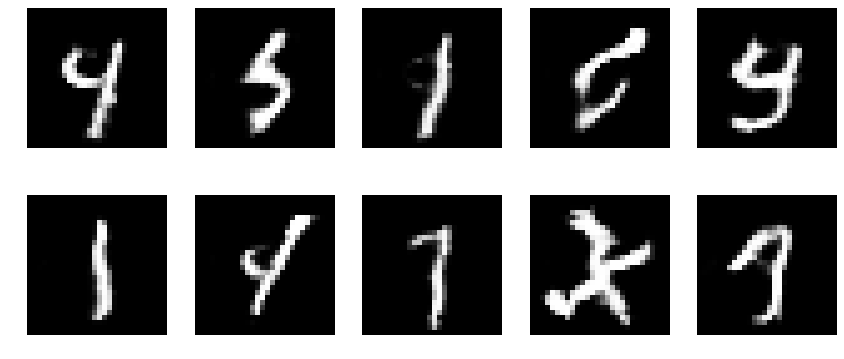

Epoch 14: gl_loss = 0.567773699760437, dl_loss =0.1812569797039032


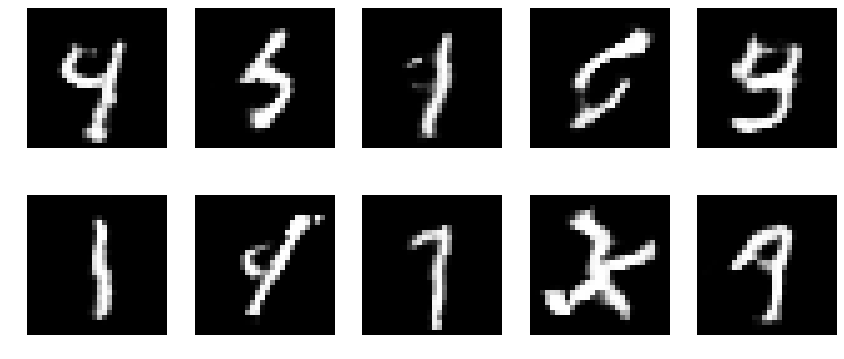

Epoch 15: gl_loss = 0.5621207356452942, dl_loss =0.20409289002418518


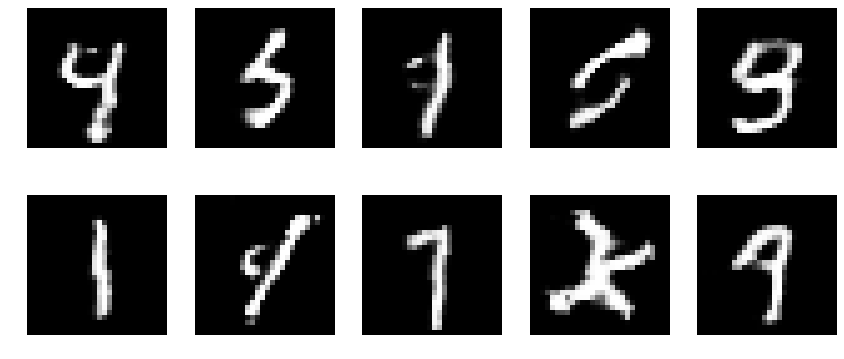

Epoch 16: gl_loss = 0.5675548315048218, dl_loss =0.1763298660516739


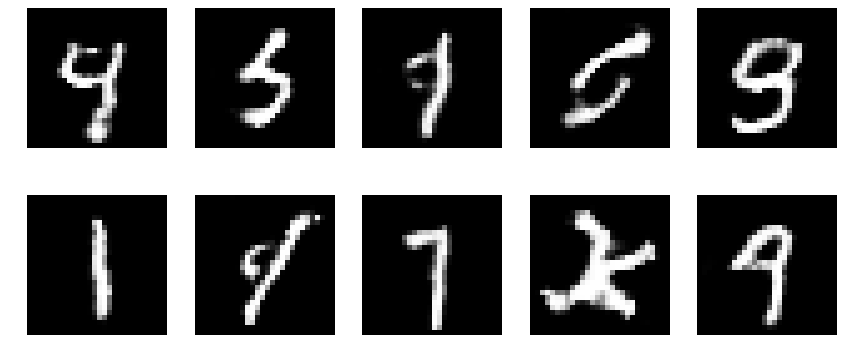

Epoch 17: gl_loss = 0.5718668699264526, dl_loss =0.17196518182754517


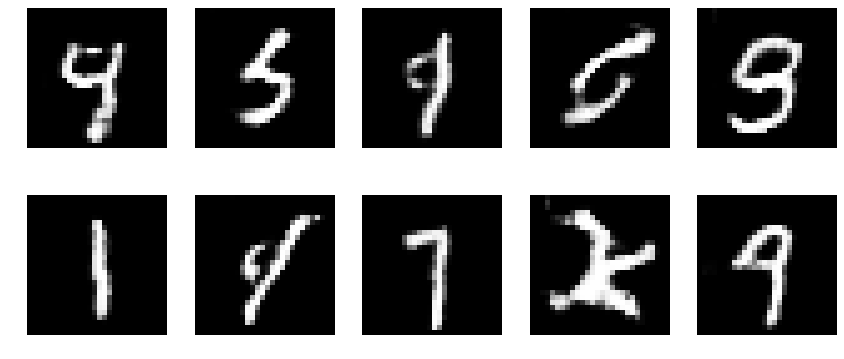

Epoch 18: gl_loss = 0.5841689109802246, dl_loss =0.12984693050384521


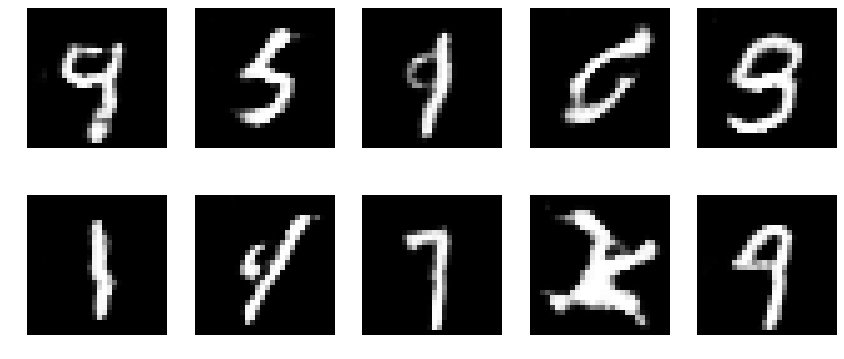

Epoch 19: gl_loss = 0.5750113725662231, dl_loss =0.16721253097057343


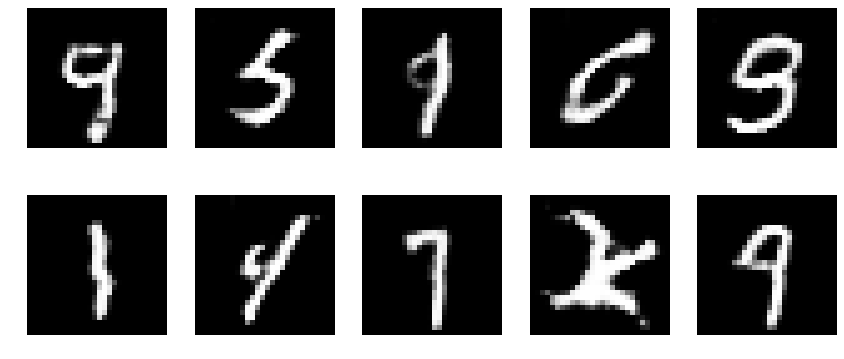

Epoch 20: gl_loss = 0.5802350640296936, dl_loss =0.14750823378562927


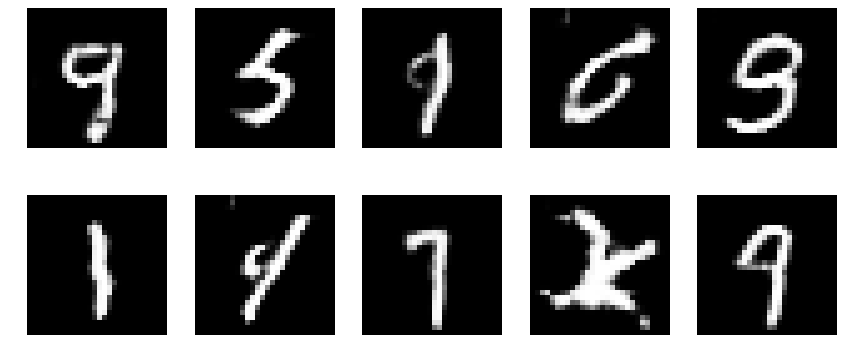

Epoch 21: gl_loss = 0.5758562088012695, dl_loss =0.15002751350402832


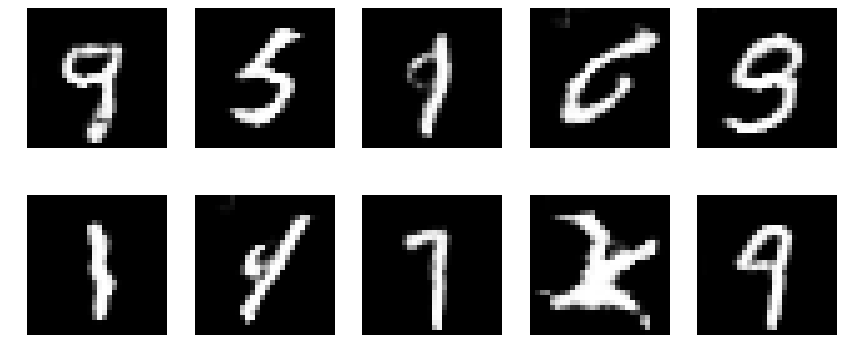

Epoch 22: gl_loss = 0.6118540167808533, dl_loss =0.12385664135217667


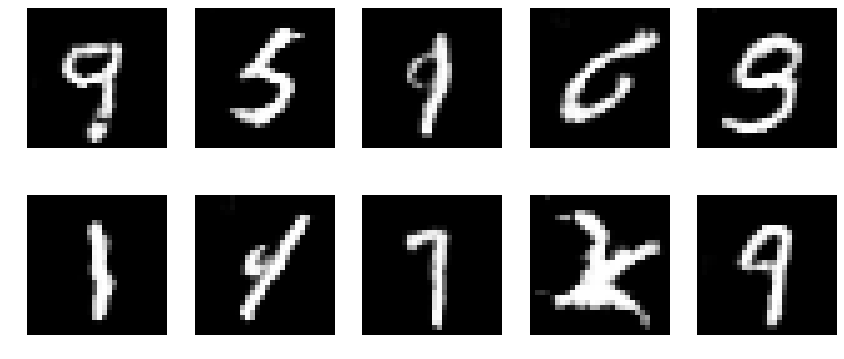

Epoch 23: gl_loss = 0.576701819896698, dl_loss =0.16110047698020935


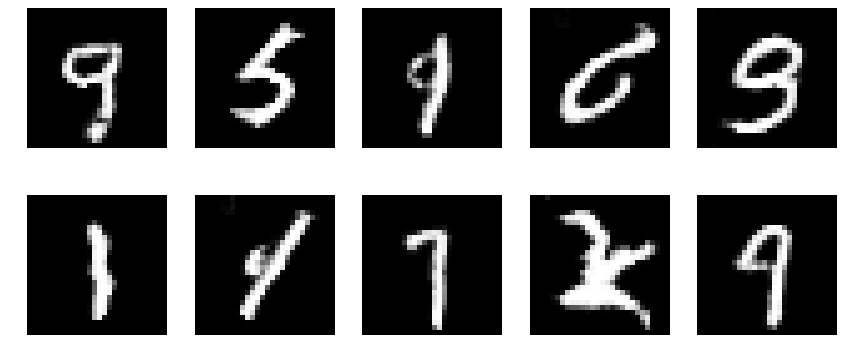

Epoch 24: gl_loss = 0.5778853893280029, dl_loss =0.154352068901062


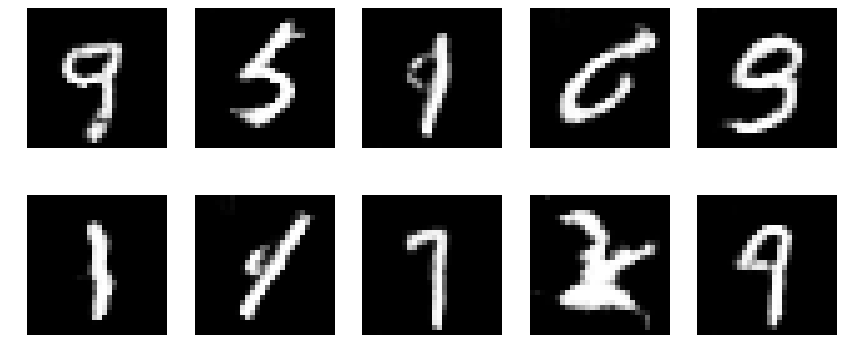

Epoch 25: gl_loss = 0.5836349725723267, dl_loss =0.14997494220733643


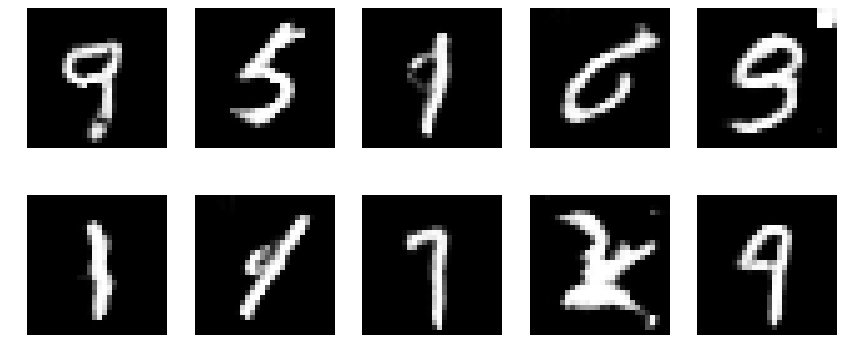

Epoch 26: gl_loss = 0.5836449265480042, dl_loss =0.1557728499174118


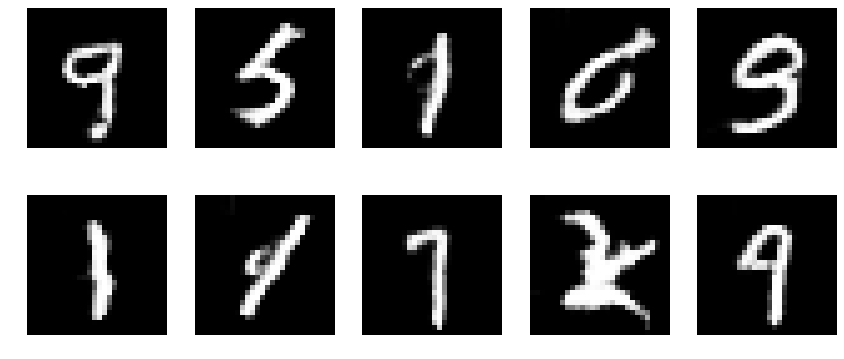

Epoch 27: gl_loss = 0.587384819984436, dl_loss =0.15254993736743927


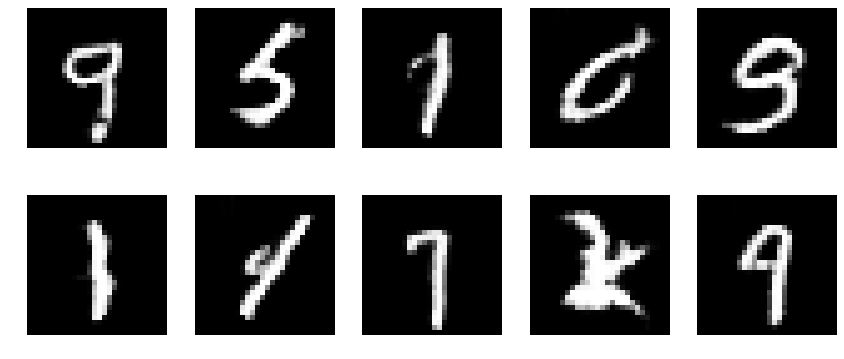

Epoch 28: gl_loss = 0.5676301121711731, dl_loss =0.16866040229797363


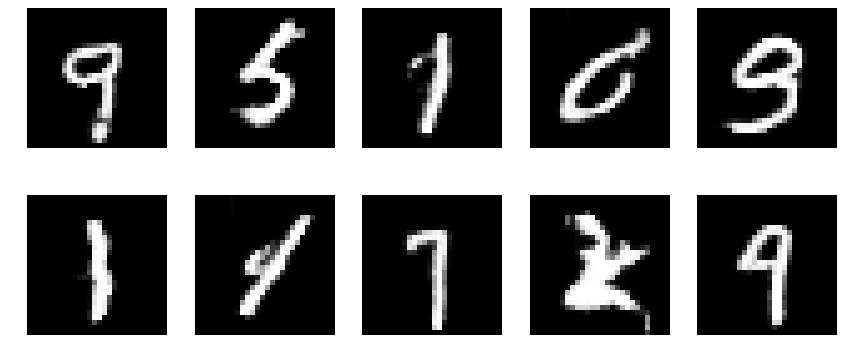

Epoch 29: gl_loss = 0.5758760571479797, dl_loss =0.17063365876674652


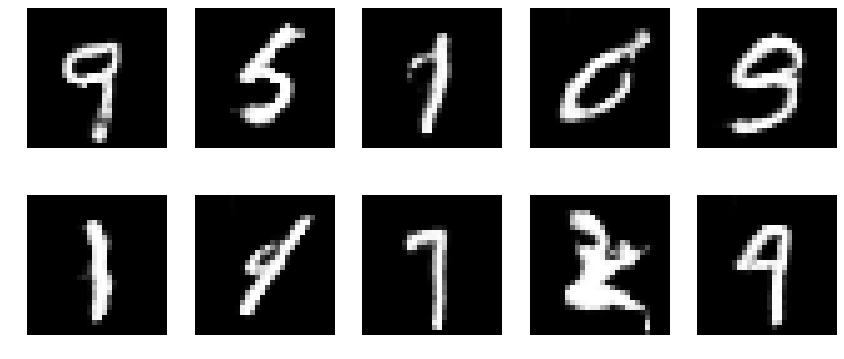

Epoch 30: gl_loss = 0.5906647443771362, dl_loss =0.14389640092849731


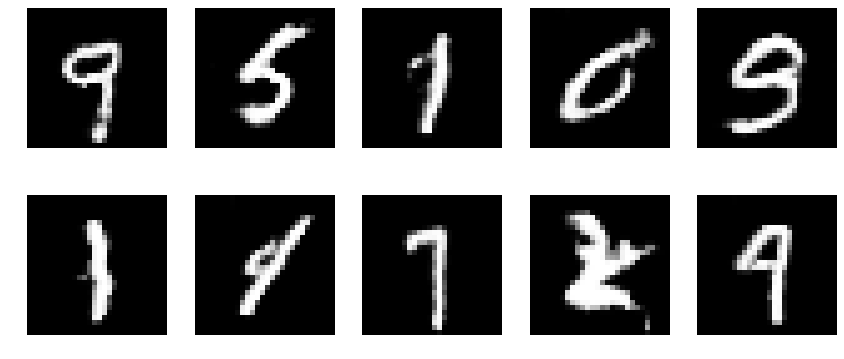

KeyboardInterrupt: 

In [14]:
for i in range (50):
    for j in range(mydata.total_batches):
        batch = mydata.get_batch()
        noise = np.random.normal(size=[BATCH_SIZE,latent_dims])
        gl_val,dl_val,_,__ = sess.run([gen_loss,dis_loss,gen_train,dis_train],feed_dict={z:noise, x:batch})
    disLoss_his.append(dl_val)
    genLoss_his.append(gl_val)
    print("Epoch {}: gl_loss = {}, dl_loss ={}".format(i,gl_val,dl_val))
    show_sample(test_noise)
    plt.pause(1e-12)

In [ ]:
plt.subplot(211)
plt.plot(genLoss_his)
plt.title("Generator Loss")
plt.subplot(212)
plt.plot(disLoss_his)
plt.title("Discriminator Loss")
plt.subplots_adjust(right=2,top=1.5)